In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import sys
import pickle
import pandas as pd

from pathlib import Path
from typing import List, Union

import matplotlib.pyplot as plt
import numpy as np
import tqdm
from sklearn.model_selection import train_test_split

from wisard.encoders import ThermometerEncoder, encode_dataset
from wisard.wisard import WiSARD, model_from_coded_mental_image
from wisard.utils import untie, get_random_permutation, permute_dataset_bits
from wisard.optimize import find_best_bleach_bayesian, find_best_bleach_bin_search


%matplotlib inline

In [3]:
mnist_file = Path("mnist.pkl")
mnist_shuffled_file = Path("mnist_shuffled.pkl")

In [156]:
def load_mnist(fname: Path):
    with fname.open("rb") as f:
        return pickle.load(f)


def display_mnist_dist(
    X,
    y,
    figsize=(16, 8),
    vmin: float = None,
    vmax: float = None,
    cmap: str = "gray",
    start: int = 0,
    end: int = 256,
    quantiles: List[float] = None
):
    fig, axs = plt.subplots(2, 5, figsize=figsize, constrained_layout=True)

    for d in range(10):
        values = {i: 0 for i in range(0, 256)}
        numbers = [x for x, y in zip(x_train, y) if y == d]

        for x in numbers:
            unique = np.unique(x, return_counts=True)
            for i, c in zip(*unique):
                values[i] += c

        xs = [i for i in range(start, end)]
        ys = [values[i] for i in range(start, end)]
        im = axs[d % 2, d % 5].plot(xs, ys)

        if quantiles is not None:
            for q in quantiles:
                axs[d % 2, d % 5].axvline(q, color="r", linestyle="--", alpha=0.5)

    plt.show()


def qcut(X, resolution):    
    for q in range(resolution, resolution*10):
        result = pd.qcut(X.ravel(), q=q, duplicates="drop")
        if len(result.categories) == resolution:
            intervals = [0] + [x.right for x in result.categories]
            return intervals
        # print(f"quantiles={q}, n_categories={len(result.categories)}")
    raise ValueError("Could not find split")


def qcut_binsearch(X, resolution):
    res_min = resolution
    res_max = resolution * 10
    last_q = 0

    while res_min < res_max:
        q = (res_max + res_min) // 2
        result = pd.qcut(X.ravel(), q=q, duplicates="drop")
        size = len(result.categories)
        print(f"Value of q: {q}, size: {size}, res_min: {res_min}, res_max: {res_max}")

        if size == resolution:
            intervals = [0] + [x.right for x in result.categories]
            return intervals

        if size > resolution:
            res_max = q
        else:
            res_min = q

        # Not needed
        if last_q == q:
            break
        else:
            last_q = q

    raise ValueError("Could not find split")


def cut(X, resolution):
    return np.linspace(X.ravel().min(), X.ravel().max(), resolution)

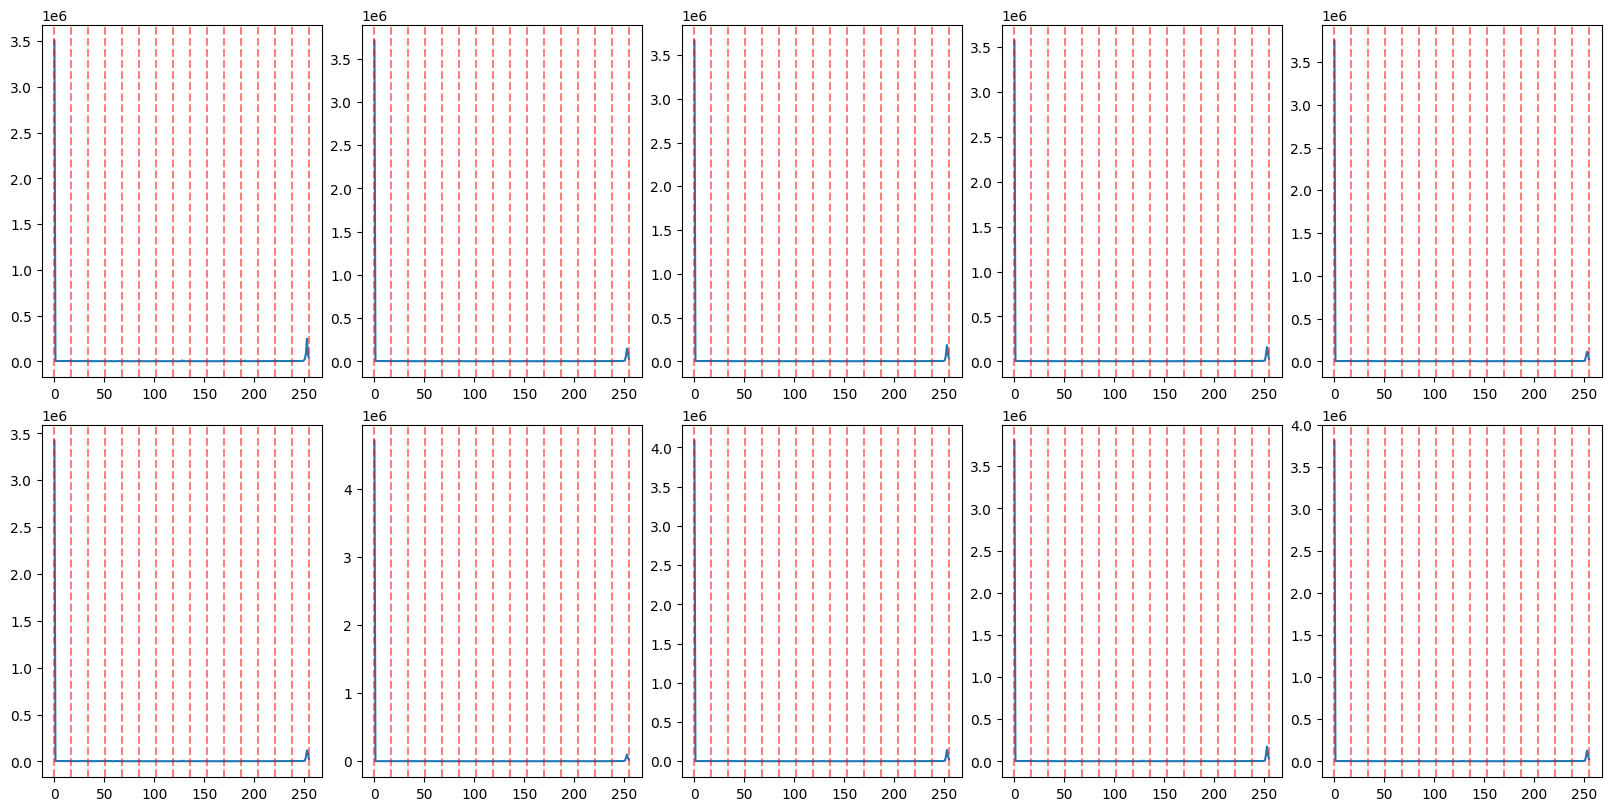

In [5]:
(x_train, y_train), (x_test, y_test) = load_mnist(mnist_file)
intervals = cut(x_train, 16)
display_mnist_dist(x_train, y_train, quantiles=intervals)

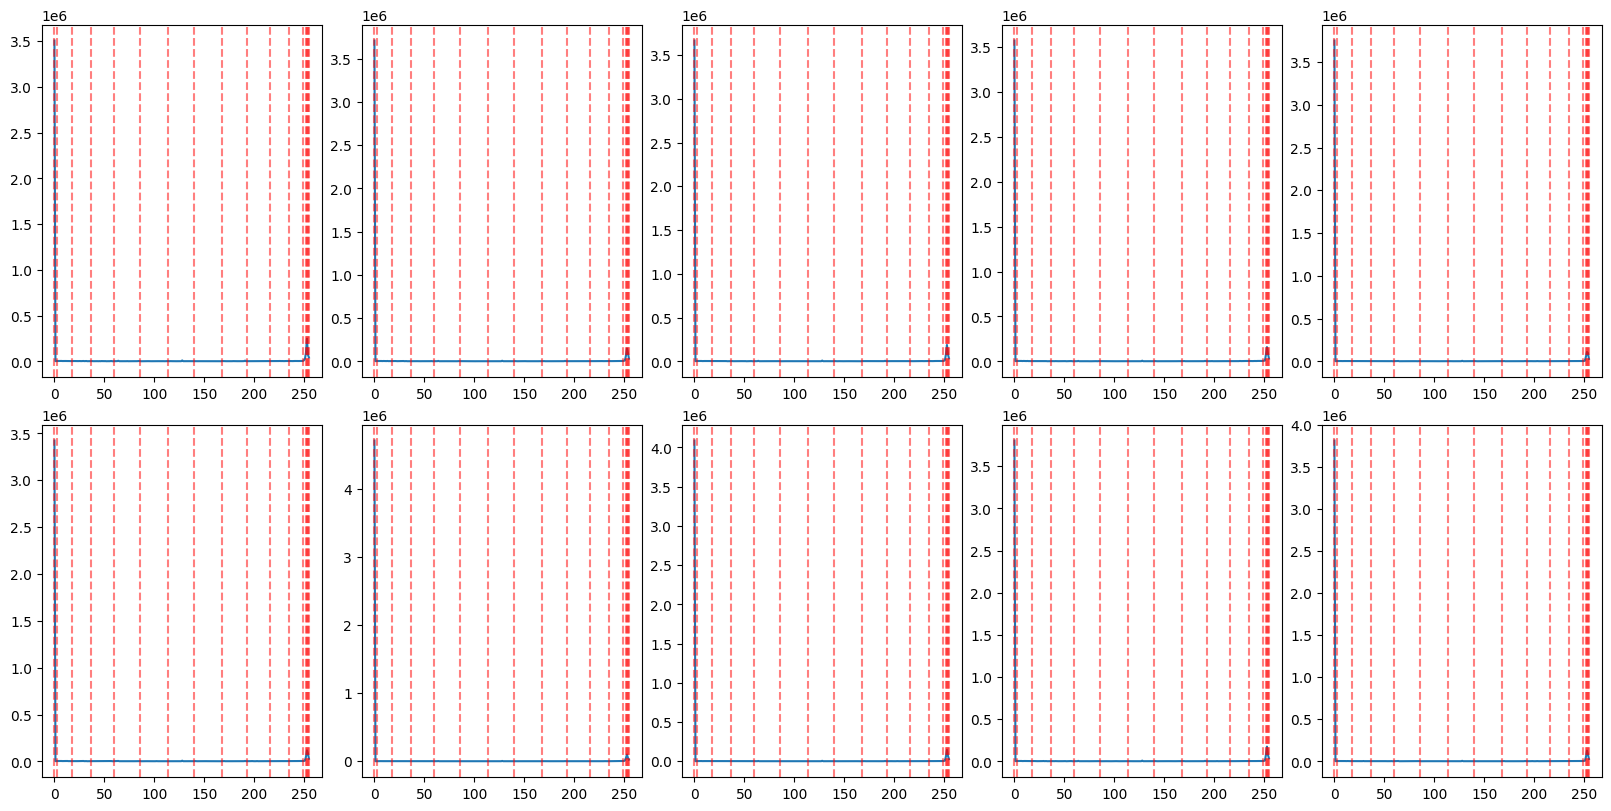

In [6]:
(x_train, y_train), (x_test, y_test) = load_mnist(mnist_file)
intervals = qcut(x_train, 16)
display_mnist_dist(x_train, y_train, quantiles=intervals)

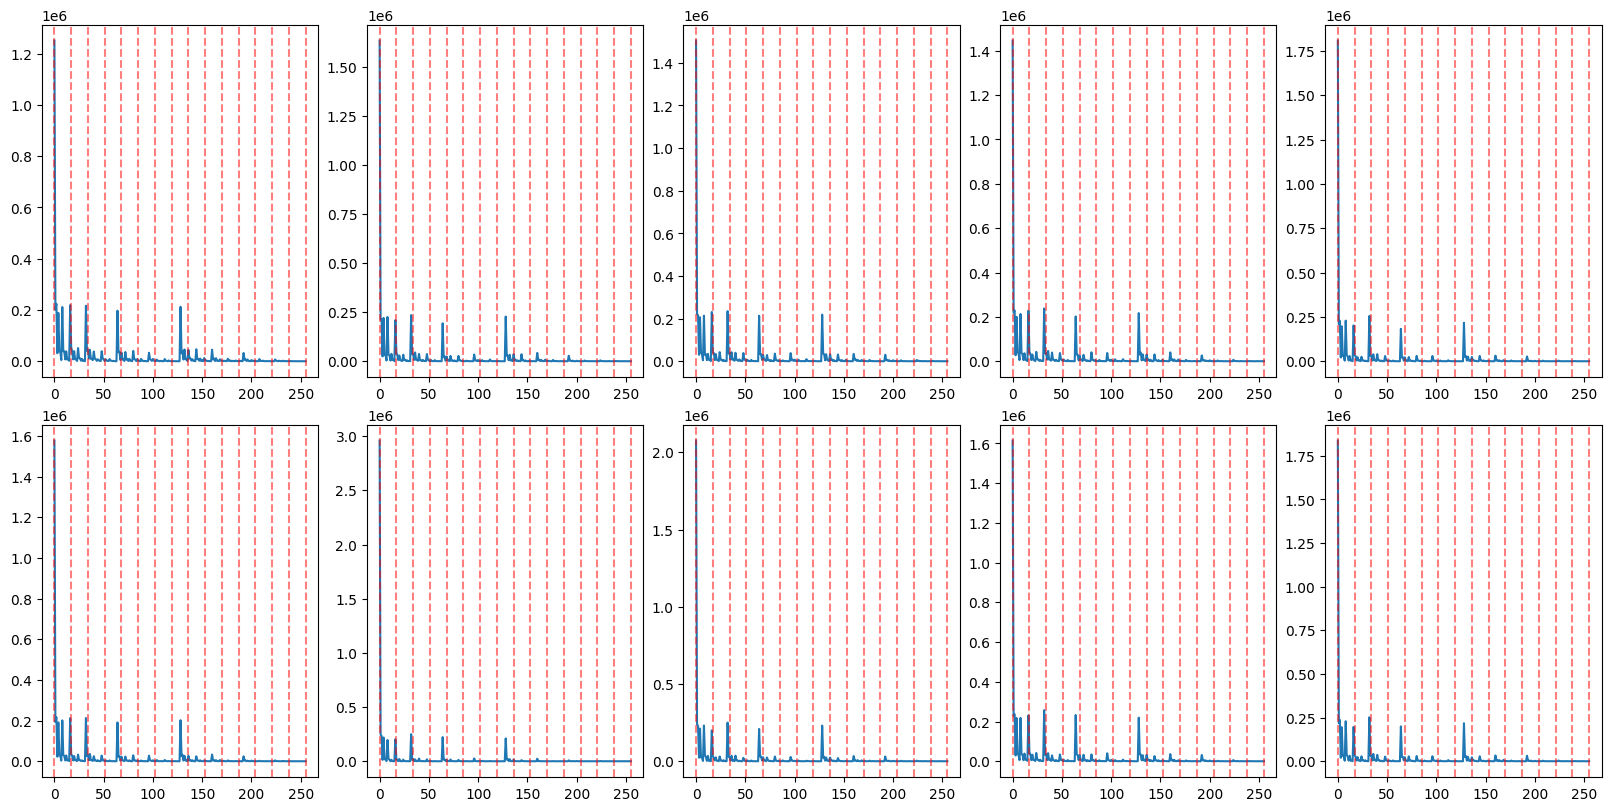

In [7]:
(x_train, y_train), (x_test, y_test) = load_mnist(mnist_shuffled_file)
intervals = cut(x_train, 16)
display_mnist_dist(x_train, y_train, quantiles=intervals)

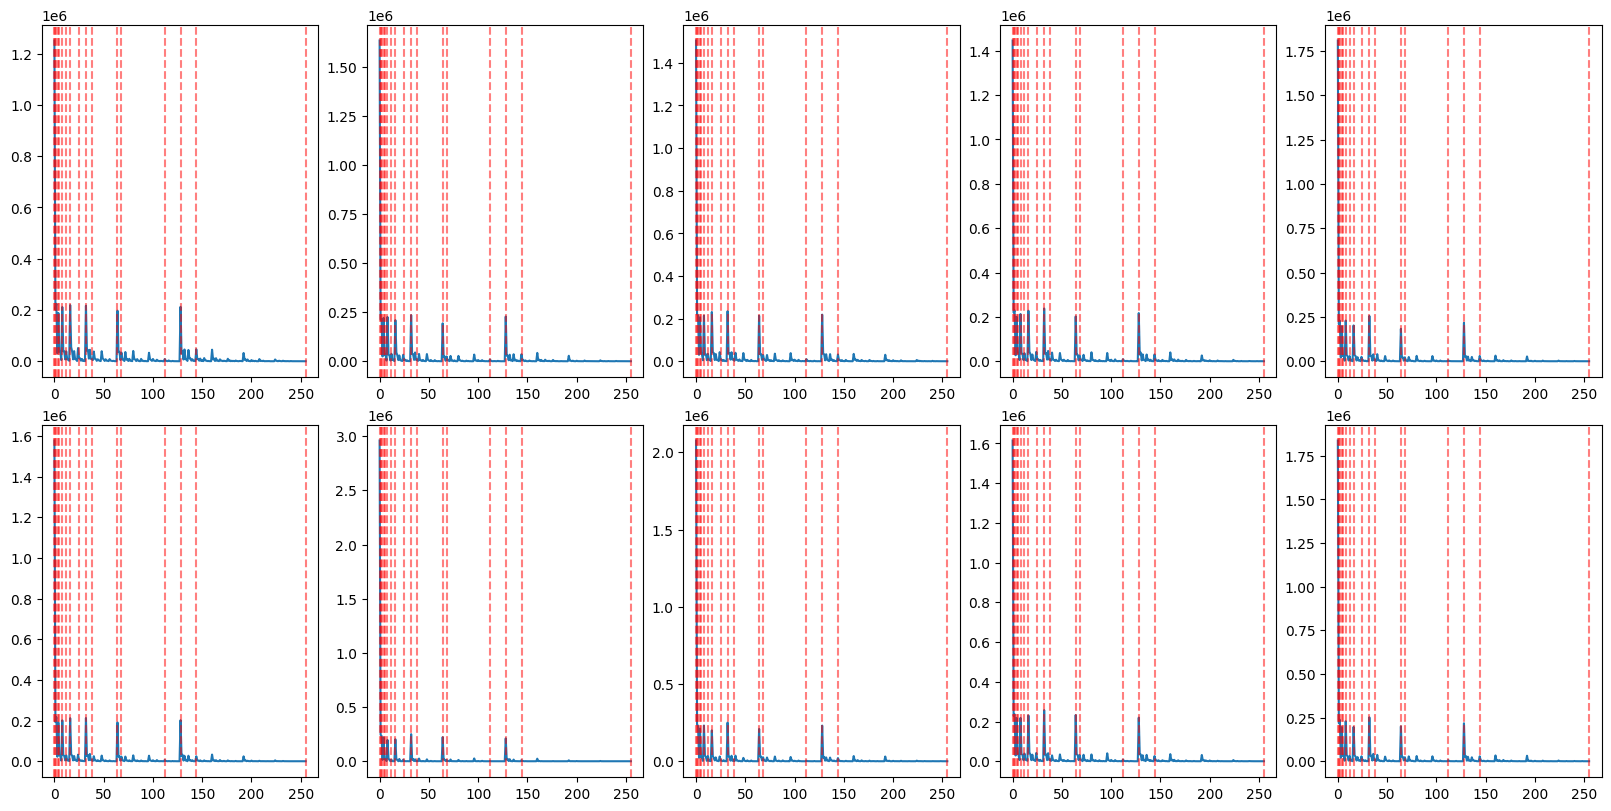

In [8]:
(x_train, y_train), (x_test, y_test) = load_mnist(mnist_shuffled_file)
intervals = qcut(x_train, 16)
display_mnist_dist(x_train, y_train, quantiles=intervals)

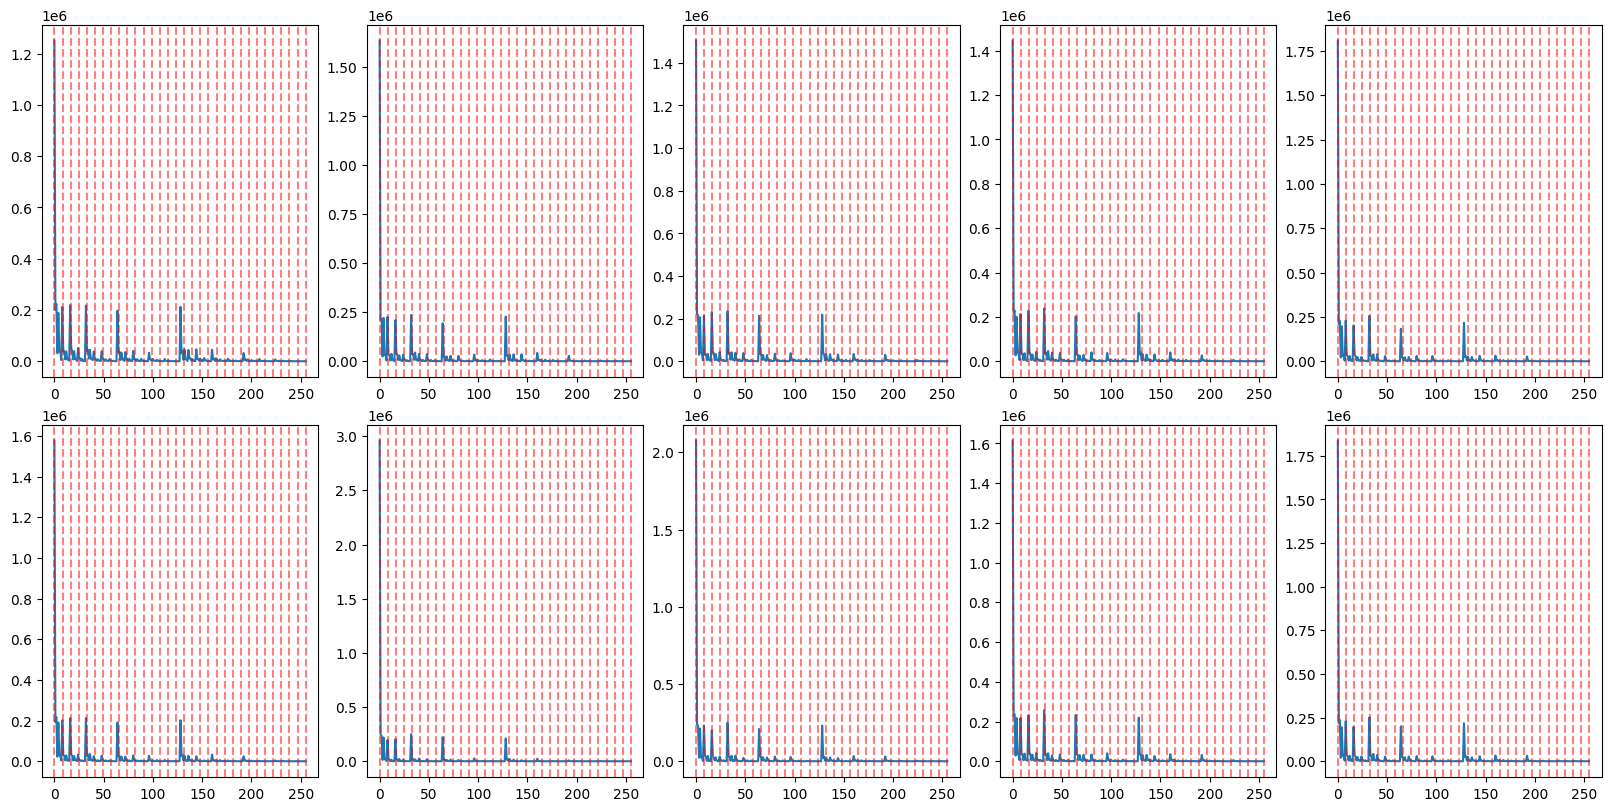

In [29]:
(x_train, y_train), (x_test, y_test) = load_mnist(mnist_shuffled_file)
intervals = cut(x_train, 32)
display_mnist_dist(x_train, y_train, quantiles=intervals)

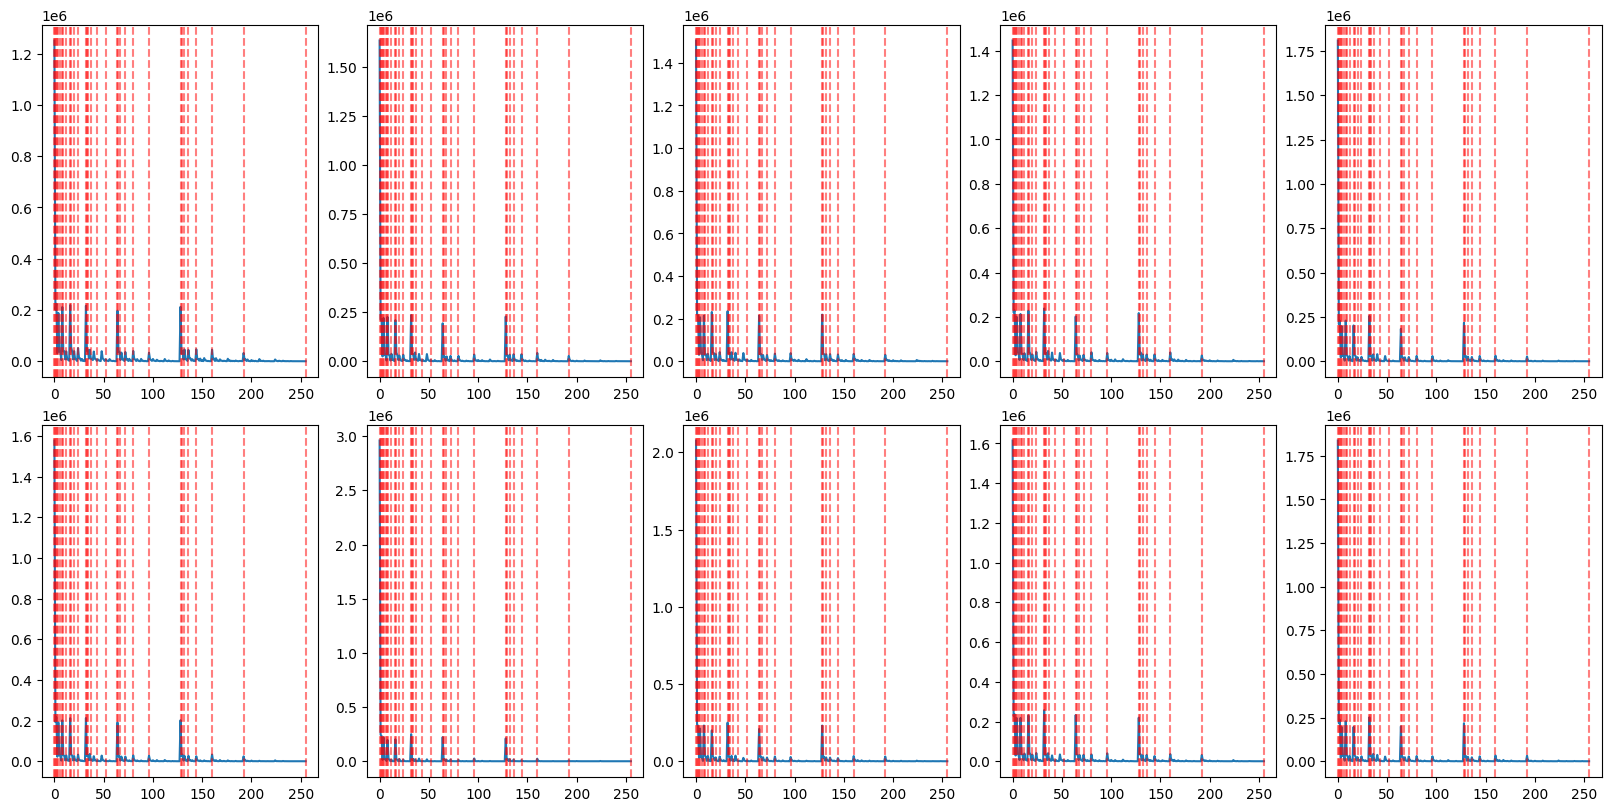

In [51]:
(x_train, y_train), (x_test, y_test) = load_mnist(mnist_shuffled_file)
intervals = qcut(x_train, 32)
display_mnist_dist(x_train, y_train, quantiles=intervals)

Value of q: 352, size: 60, res_min: 64, res_max: 640
Value of q: 496, size: 69, res_min: 352, res_max: 640
Value of q: 424, size: 67, res_min: 352, res_max: 496
Value of q: 388, size: 67, res_min: 352, res_max: 424
Value of q: 370, size: 62, res_min: 352, res_max: 388
Value of q: 379, size: 63, res_min: 370, res_max: 388
Value of q: 383, size: 61, res_min: 379, res_max: 388
Value of q: 385, size: 63, res_min: 383, res_max: 388
Value of q: 386, size: 64, res_min: 385, res_max: 388


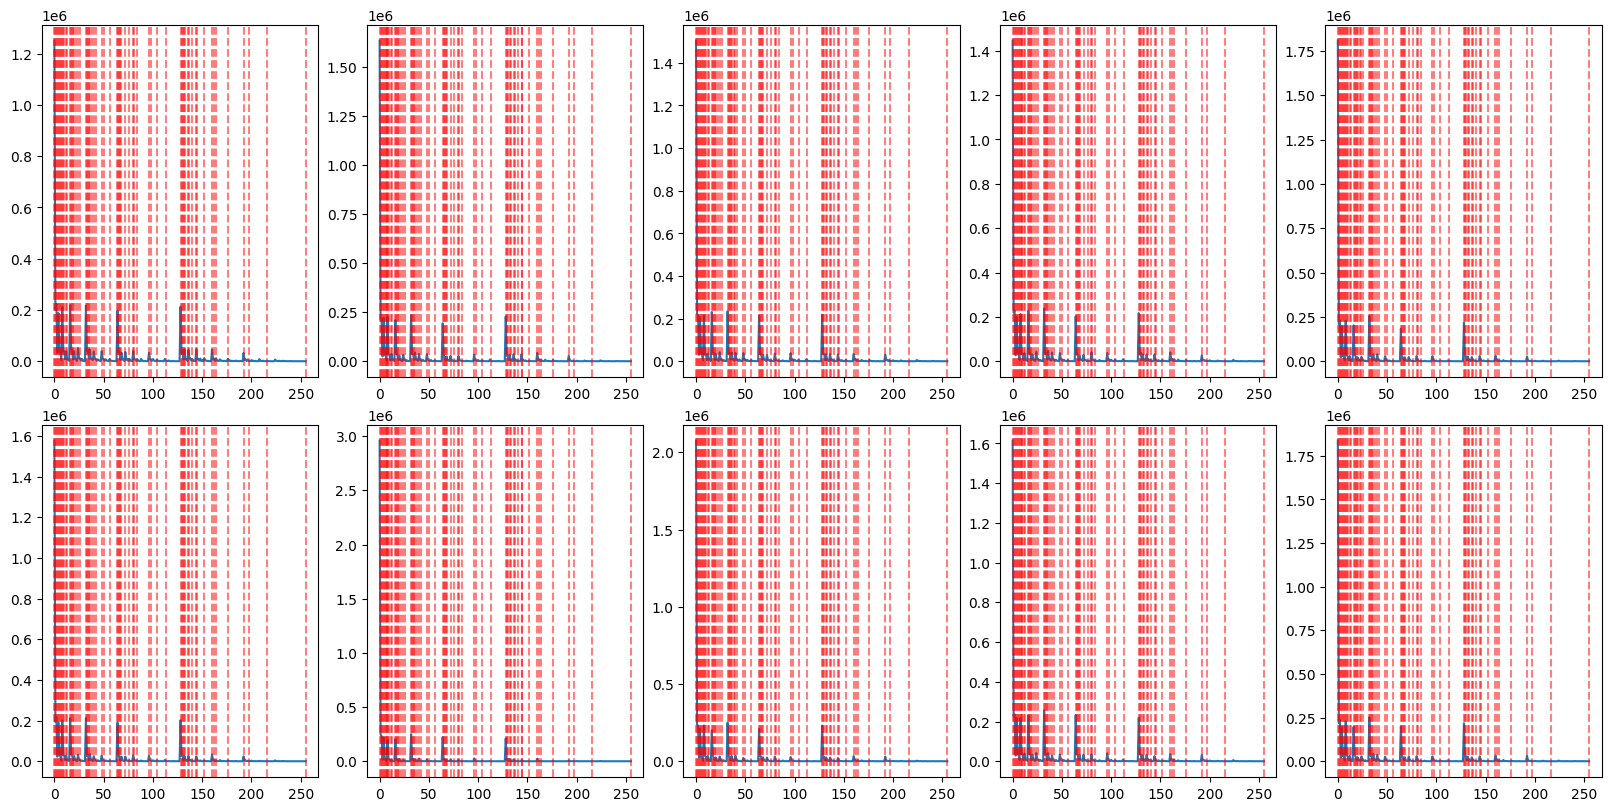

In [157]:
(x_train, y_train), (x_test, y_test) = load_mnist(mnist_shuffled_file)
intervals = qcut_binsearch(x_train, 64)
display_mnist_dist(x_train, y_train, quantiles=intervals)

In [164]:
import pandas as pd


class DistributiveThermometer:
    def __init__(self, resolution: int):
        self.resolution = resolution
        self.quantiles = []
        self.encoding = {
            bucket: np.array(
                int_to_binary_list((2**bucket) - 1, size=self.resolution)
            ).astype(np.uint8)
            for bucket in range(self.resolution + 1)
        }

    def fit(self, X, y=None):
        res_min = self.resolution
        res_max = self.resolution * 10
        last_q = 0

        while res_min < res_max:
            q = (res_max + res_min) // 2
            result = pd.qcut(X.ravel(), q=q, duplicates="drop")
            size = len(result.categories)
            print(f"q: {q}, size: {size}, min: {res_min}, max: {res_max}")

            if size == self.resolution:
                self.quantiles = [x.right for x in result.categories]
                return self

            if size > self.resolution:
                res_max = q
            else:
                res_min = q

            # Not needed
            if last_q == q:
                break
            else:
                last_q = q

        raise ValueError("Could not find split")

    def encode(self, X):
        inds = np.digitize(X.ravel(), self.quantiles, right=False)
        coded_x = [
            np.expand_dims(self.encoding[i], axis=1).astype(np.uint8) for i in inds
        ]
        return np.hstack(coded_x).ravel()

In [165]:
dthermometer = DistributiveThermometer(resolution=60).fit(x_train)

q: 330, size: 63, min: 60, max: 600
q: 195, size: 53, min: 60, max: 330
q: 262, size: 57, min: 195, max: 330
q: 296, size: 59, min: 262, max: 330
q: 313, size: 58, min: 296, max: 330
q: 321, size: 62, min: 313, max: 330
q: 317, size: 58, min: 313, max: 321
q: 319, size: 61, min: 317, max: 321
q: 318, size: 60, min: 317, max: 319


In [166]:
new_x_train = encode_dataset(dthermometer, x_train)
new_x_test = encode_dataset(dthermometer, x_test)

Encoding dataset: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:33<00:00, 301.29it/s]


In [167]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from wisard.wisard import WiSARD

def do_train_and_evaluate(x_train,
                          y_train,
                          x_test,
                          y_test,
                          tuple_size: int,
                          input_indexes: List[int],
                          bleach: Union[int, str] = "linear_search",
                          use_tqdm: bool = False) -> dict:
    num_classes = len(np.unique(y_train))

    print(" ----- Training model ----- ")
    print(f"input_indexes: {input_indexes}")
    print(f"tuple size: {tuple_size}")
    print(f"x_train.shape: {x_train.shape}")
    print(f"x_test.shape: {x_test.shape}")
    print(f"num classes: {num_classes}")

    model = WiSARD(num_inputs=x_train[0].size,
                   num_classes=num_classes,
                   unit_inputs=tuple_size,
                   unit_entries=1,
                   unit_hashes=1,
                   input_idxs=input_indexes,
                   shared_rand_vals=False,
                   randomize=False,
                   use_dict=True)

    model.fit(x_train, y_train, use_tqdm=use_tqdm)
    max_bleach = model.max_bleach()
    print(f"Max bleach is: {max_bleach}\n")

    print(" ----- Evaluating model ----- ")

    if isinstance(bleach, int):
        y_pred = model.predict(x_test, y_test, bleach=bleach, use_tqdm=use_tqdm)
        y_pred, ties = untie(y_pred, use_tqdm=False)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"[b={bleach}] Accuracy={accuracy:.3f}, ties={ties}")
    elif bleach == "linear_search":
        bleach = find_best_bleach_bin_search(model,
                                             X=x_test,
                                             y=y_test,
                                             min_bleach=1,
                                             max_bleach=max_bleach//2,
                                             use_tqdm=use_tqdm)
    elif bleach == "bayesian_search":
        bleach = find_best_bleach_bayesian(model,
                                           X=x_test,
                                           y=y_test,
                                           min_bleach=1,
                                           max_bleach=max_bleach//2,
                                           use_tqdm=use_tqdm)
    else:
        raise ValueError(f"Invalid value for bleach: '{bleach}'")

    return model, bleach

In [168]:
input_size = new_x_train[0].size
input_indexes = np.arange(input_size).reshape(60, -1).T.ravel()
input_indexes

array([    0,   784,  1568, ..., 45471, 46255, 47039])

In [169]:
do_train_and_evaluate(
    new_x_train,
    y_train,
    new_x_test,
    y_test,
    input_indexes=input_indexes,
    tuple_size=60,
    use_tqdm=True
)

 ----- Training model ----- 
input_indexes: [    0   784  1568 ... 45471 46255 47039]
tuple size: 60
x_train.shape: (60000, 47040)
x_test.shape: (10000, 47040)
num classes: 10


Training model: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [02:50<00:00, 351.54it/s]


Max bleach is: 6734

 ----- Evaluating model ----- 
Testing with bleach=842


Evaluating model: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:36<00:00, 46.12it/s]


[b=842] Accuracy=0.793, ties=76
Testing with bleach=1683


Evaluating model: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:37<00:00, 45.94it/s]


[b=1683] Accuracy=0.511, ties=107
Testing with bleach=2524


Evaluating model: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:37<00:00, 45.97it/s]


[b=2524] Accuracy=0.200, ties=50
Testing with bleach=422


Evaluating model: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:37<00:00, 45.88it/s]


[b=422] Accuracy=0.832, ties=61
Testing with bleach=842
[b=842] Accuracy=0.793
Testing with bleach=1262


Evaluating model: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:36<00:00, 46.15it/s]


[b=1262] Accuracy=0.687, ties=101
Testing with bleach=212


Evaluating model: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:35<00:00, 46.35it/s]


[b=212] Accuracy=0.837, ties=72
Testing with bleach=422
[b=422] Accuracy=0.832
Testing with bleach=632


Evaluating model: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:35<00:00, 46.42it/s]


[b=632] Accuracy=0.818, ties=71
Testing with bleach=107


Evaluating model: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:36<00:00, 46.28it/s]


[b=107] Accuracy=0.829, ties=163
Testing with bleach=212
[b=212] Accuracy=0.837
Testing with bleach=317


Evaluating model: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:35<00:00, 46.36it/s]


[b=317] Accuracy=0.835, ties=55
Testing with bleach=160


Evaluating model: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:36<00:00, 46.27it/s]


[b=160] Accuracy=0.836, ties=79
Testing with bleach=212
[b=212] Accuracy=0.837
Testing with bleach=264


Evaluating model: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:35<00:00, 46.44it/s]


[b=264] Accuracy=0.835, ties=80
Testing with bleach=186


Evaluating model: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:35<00:00, 46.41it/s]


[b=186] Accuracy=0.838, ties=76
Testing with bleach=212
[b=212] Accuracy=0.837
Testing with bleach=238


Evaluating model: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:35<00:00, 46.33it/s]


[b=238] Accuracy=0.835, ties=77
Testing with bleach=173


Evaluating model: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:36<00:00, 46.28it/s]


[b=173] Accuracy=0.838, ties=82
Testing with bleach=186
[b=186] Accuracy=0.838
Testing with bleach=199


Evaluating model: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:35<00:00, 46.37it/s]


[b=199] Accuracy=0.838, ties=89
Testing with bleach=193


Evaluating model: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:35<00:00, 46.35it/s]


[b=193] Accuracy=0.839, ties=87
Testing with bleach=199
[b=199] Accuracy=0.838
Testing with bleach=205


Evaluating model: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:34<00:00, 46.58it/s]


[b=205] Accuracy=0.836, ties=98
Testing with bleach=190


Evaluating model: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:35<00:00, 46.50it/s]


[b=190] Accuracy=0.838, ties=89
Testing with bleach=193
[b=193] Accuracy=0.839
Testing with bleach=196


Evaluating model: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:35<00:00, 46.46it/s]


[b=196] Accuracy=0.839, ties=95
Testing with bleach=192


Evaluating model: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:35<00:00, 46.42it/s]


[b=192] Accuracy=0.839, ties=80
Testing with bleach=193
[b=193] Accuracy=0.839
Testing with bleach=194


Evaluating model: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:35<00:00, 46.37it/s]


[b=194] Accuracy=0.840, ties=89
Testing with bleach=193
[b=193] Accuracy=0.839
Testing with bleach=194
[b=194] Accuracy=0.840
Testing with bleach=195


Evaluating model: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:37<00:00, 45.98it/s]

[b=195] Accuracy=0.840, ties=98
Testing with bleach=194
[b=194] Accuracy=0.840
Testing with bleach=195
[b=195] Accuracy=0.840
Testing with bleach=196
[b=196] Accuracy=0.839
Best bleach: 195....


(<wisard.wisard.WiSARD at 0x7f749d2bc400>, 195)

In [39]:
from wisard.wisard import int_to_binary_list
int_to_binary_list((2**12)-1)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]

In [93]:
b = {
    bucket: np.array(int_to_binary_list((2**bucket)-1, 32))
    for bucket in range(32+1)
}

In [109]:
x = np.array([0, 1, 230, 254, 255])
inds = np.digitize(x, intervals, right=False)

x = [np.expand_dims(b[i], axis=1) for i in inds]
x = np.hstack(x).ravel()
x

array([0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 1])